----

# Preface

Lately, I've finished the Deep Learning Specialisation in Coursera conducted by _deeplearning.ai_. I was captivated by the idea of _Neural Style Transfer_ (NST) using CNNs. Hence, I've decided to try out the implementation myself.

Besides, as one who used to work with the TensorFlow framework since version 1.13. I'd also like to experience the welcoming changes of 2.1. I'm adapting the code from a helpful Tensorflow tutorial: [Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer#fast_style_transfer_using_tf-hub). This gives me an excellent position to get started.

In this notebook, we will be implementing _Neural Style Transfer_ using the original technique of single image, stepwise optimisation. This technique originates from this paper:

[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) (Gatys et al., 2015).

The modern approach, however, is to train a model that applies stylisation _directly_ onto the target image (as we'll see in the section of [Fast Style Transfer using TF-Hub](#tfhub_cell)). This technique is elaborated in this paper: 

[Exploring the structure of a real-time, arbitrary neural artistic stylization network](https://arxiv.org/abs/1705.06830) (Ghiasi et al., 2017)

The contents in this notebook are greatly simplified (and slightly modified) as its primary purpose is to give a quick low-down of the workflow and the underlying concepts of NST. As we go along, I've also annotated my learnings under each cell.

# Neural style transfer

## Import and configure modules

In [1]:
import tensorflow as tf
print(tf.__version__) # I'm running on TensorFlow version 2.1

2.1.0


In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [6]:
parent_path = '/Users/bingyuan/Development/neural-style-transfer-tf2/' # Change this to your own path

content_path = parent_path + 'content/content.jpg' # Change this to your own path
style_path = parent_path + 'style/style-1.jpg' # Change this to your own path

content_image = load_img(content_path)
style_image = load_img(style_path)

## Visualize the input

### Content Image

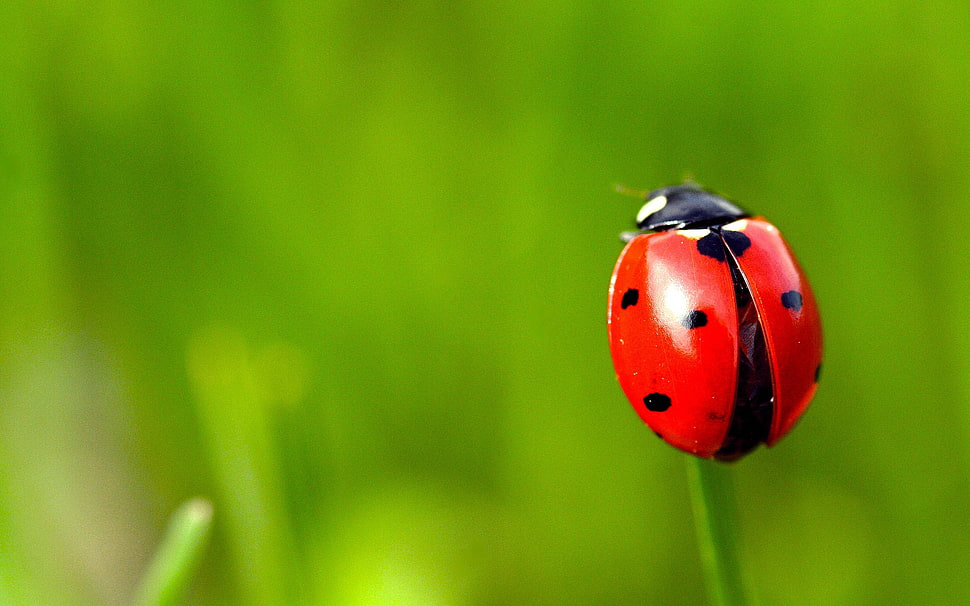

In [7]:
display.display(PIL.Image.open(parent_path + 'assets/content.jpg'))

### Style Images

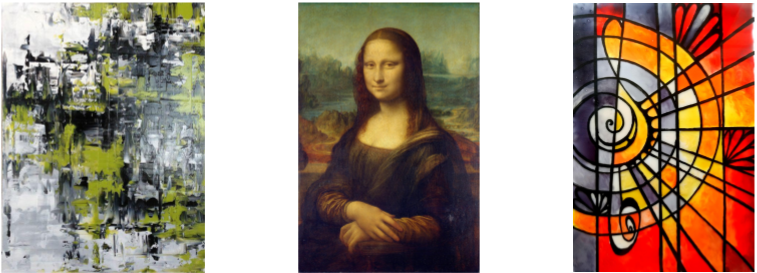

In [8]:
display.display(PIL.Image.open(parent_path + 'assets/styles-all.png'))

<a id='tfhub_cell'></a>

## Fast Style Transfer using TF-Hub

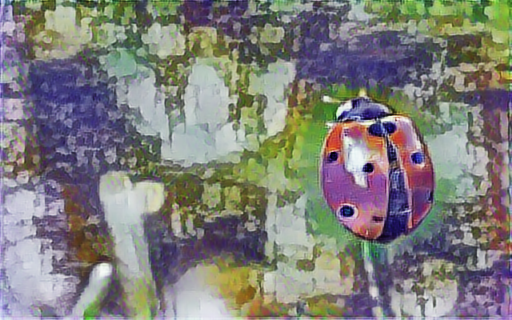

In [9]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

### Synthesised Images

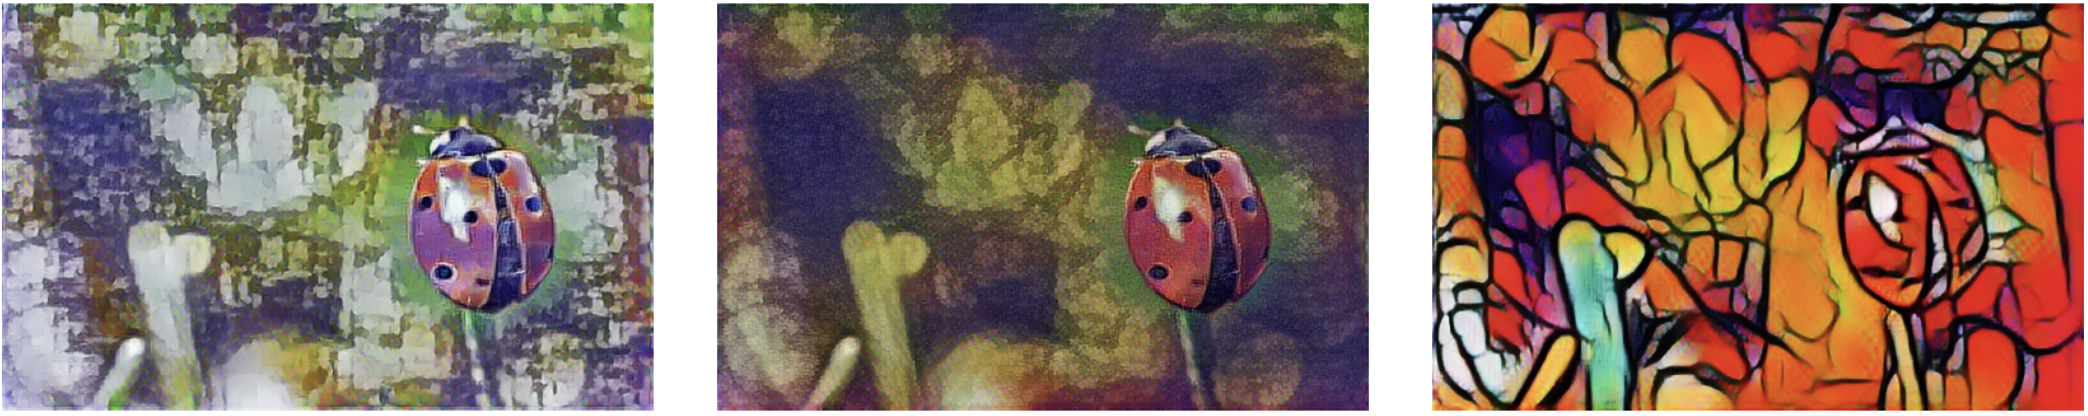

In [10]:
display.display(PIL.Image.open(parent_path + 'assets/tfhub-synthesis-all.png'))

**Note**

Having tried out with more varieties of contents and styles, I found that there are instances where the model is _over-generalising_. The trend I've noticed is a consistent overpowering shades applied to the resulting images. 

In my opinion, this understates the 'atitude' of the painted image. Compare this with our own synthesised images for example (see below). 

By the way, visuals are subjective anyway so I leave the judgment open. Although results can vary with different combinations. You are still encouraged to try it out using your own images.

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a `VGG19` without the classification head, and list the layer names

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# print()
# for layer in vgg.layers:
#     print(layer.name)

Choose intermediate layers from the network to represent the style and content of the image:


In [12]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [13]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [17]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [18]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [20]:
style_weight=1e-2 
content_weight=1e4

**Note**

You may adjust the weights to your own liking. In case you find the stylisation is overpowering, reduce `style_weight` and vice versa. Personally, I kept `content_weight` constant and only adjusts `style_weight` to get my desired image. 

You may try with both and see how it affects the resulting image.

In [21]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

## Optimize

Choose a weight for the `total_variation_loss`:

In [22]:
total_variation_weight=100

**Note**

You may adjust `total_variation_weight` to your own liking. A noticeable difference can be observed from `total_variation_weight = 30` and above. Higher magnitude should result in 'smoother' images, but you wouldn't want to overdo it!

Now include it in the `train_step` function.
Use `tf.GradientTape` to update the image:

In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

**Note**

Finally, we need to write our own training loop as we are building a custom model with custom _loss_. This is actually an advanced way of piecing together a model. 

I've learnt to appreciate the simplicity of TF2.1 even though a custom loop is warranted.

**Additional Note**

Why Total variation loss?

One downside to the basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*.

* To put it on a simpler perspective, optimising total variation loss together will have a denoising effect on the resulting image.

Now run a few steps to test:

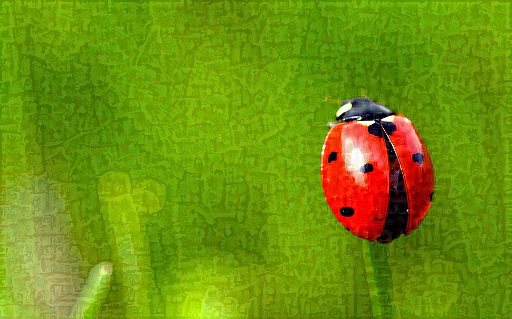

In [24]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Reinitialize the optimization variable:

In [25]:
image = tf.Variable(content_image)

And run the optimization:

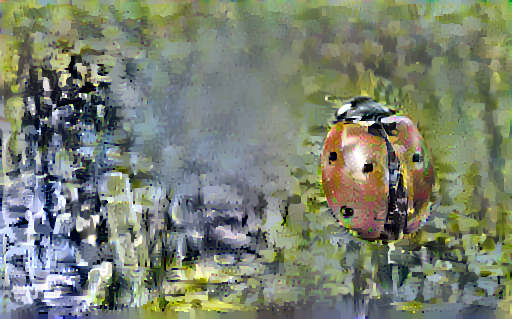

Train step: 1000
Total time: 1399.4


In [26]:
import time
start = time.time()

epochs = 10 # Adjust this to your desired epoch
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

    file_name = 'output/stylized-content3-' + str(n) + '.png'
    tensor_to_image(image).save(file_name)

end = time.time()
print("Total time: {:.1f}".format(end-start))

**Note**

Training is best run on a CUDA enabled machine. Since I'm running on a Mac, I'm bottlenecked by the CPU execution capacity. You may experience a dramatic speedup (x100s) when training on the accelerated environment of GPU.

### Synthesised Images

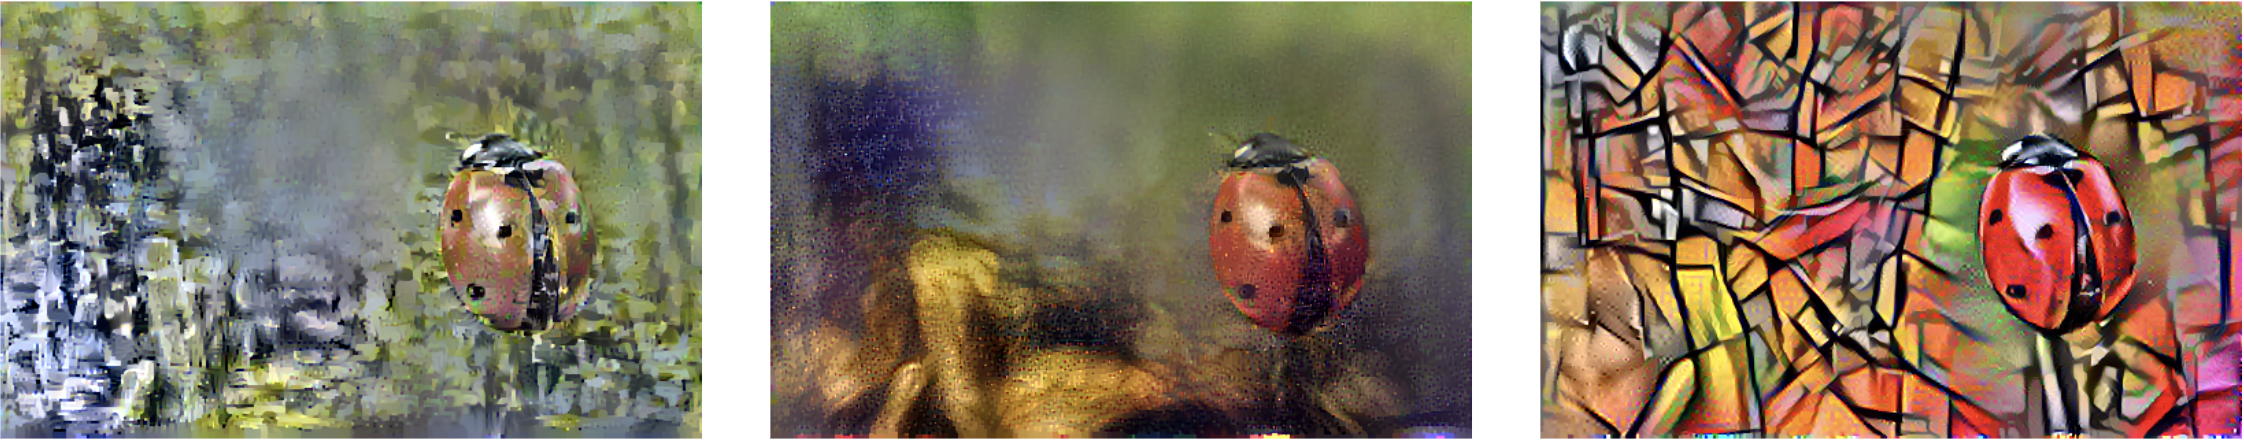

In [27]:
display.display(PIL.Image.open(parent_path + 'assets/synthesis-all.png'))

# Verdict

_Neural Style Transfer_ is an interesting field in deep learning. By going through this exercise, I have a newfound appreciation to neural networks, particularly Convolutional Neural Network (CNNs) for its ability to learn _representations_ from image pixels. Further, as we go deep, CNNs were able to pick up higher order features and function as a complex feature extractor.

Besides, this exercise motivates me to look _deep_ into the lines of building the model _per se_. It requires one to write their own model, working with intermediate outputs, as well as defining a custom loss function and optimizing it in a custom training loop. This technique will prove useful when one find themselves having to build their own models to suit their unique problem domain.

I regard this as a motivating example for a more involved model development experience and beyond.

Till next time!

----